### Salish Sea Oil Spill Scenarios

Notebook to accompany the paper on modelling oil spill scenarios in the Salish Sea using an Atlantis model. 

### Spill Scenarios
Point source spill scenarios were based on discussion with the Department of Fisheries and Oceans Canada (DFO) & Transport Canada. [Full scenario descriptions](https://docs.google.com/spreadsheets/d/17HgaXoKG5b0zkigri6Vdw7fNviDKVzzTVrbpVVRrCjk/edit?usp=sharing).

| **spill ID**  | **oil** | **spill size (m^3)** | **season** | **location** |
|---------|---------|--------------------|------------|--------------|
| 6a | Bunker C| 15 | summer, flood tide | leaving Vancouver Harbour, at Anchorage|
| 4a | Diesel | 500 | summer, ebb tide | Active Pass |
| 7a | Bunker C| 1000 | winter storm, flood tide | Strait of Juan de Fuca |
| 5b | Dilbit | 2000 | winter, ebb tide | Turn Point, Arachne Reef |

### Salish Sea Conditions and date selection
Timing of spill scenarios were chosen to capture variations in the following site conditions *(notebook: contaminant-dispersal/Site-conditions.ipynb)*

- Tides, taken from [DFO-Pacific website](https://www.pac.dfo-mpo.gc.ca/science/charts-cartes/obs-app/observed-eng.aspx?StationID=07735) at the nearest tide gauge. 
- Surface winds, from hourly atmospheric field values from the Environment Canada High Resolution Deterministic Prediction System (HRDPS) atmospheric forcing model.
- Fraser River Discharge (m^3), from SalishSeaCast.




### Parcing Ocean Parcels output into Atlantis input files

Steps 
1. Map the spill using ocean parcels *(notebook: contaminant-dispersal/SSAM-parcels.ipynb)*
1. Convert the ocean parcels spill map into Atlantis input file *(notebook: contaminant-dispersal/SSAM-parse-tracks.ipynb)*
1. Store individual input files for each spill scenario in *contaminant-dispersal/results/* folder

### Visualizing spill footprints
- Animations of spill footprints and the variation in relative concentrations of oil over time were created using *(notebook: contaminant-dispersal/SSAM-box-oil-anime.ipynb)*
- Animations of corresponding particle trajectories from Ocean Parcels overlayed on the Atlantis grid were created using *(notebook: contaminant-dispersal/SSAM-box-particle-animation)*


In [1]:
from parcels import plotTrajectoriesFile

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2926/libparcels_random_c7b17b9f-42e1-431a-b8cf-aae4937cda27.so


#### Active Pass Diesel spill trajectories

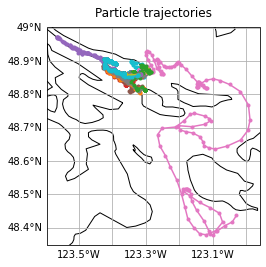

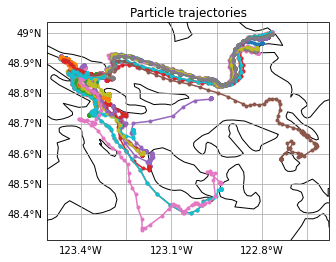

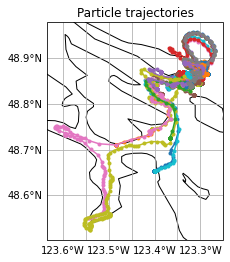

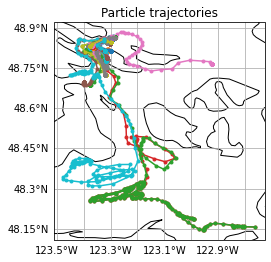

In [10]:
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/4a_ActivePass_Diesel_2019-07-10_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/4a_ActivePass_Diesel_2019-07-16_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/4a_ActivePass_Diesel_2020-07-12_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/4a_ActivePass_Diesel_2020-07-20_OP_D50_wp3.nc');

#### Turn Point Dilbit spill trajectories

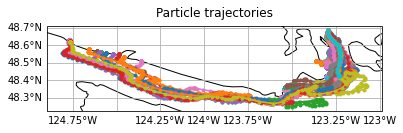

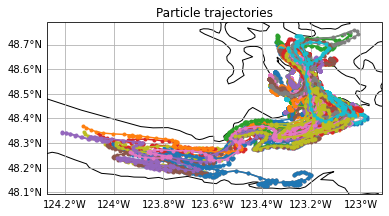

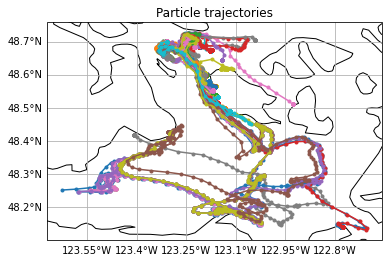

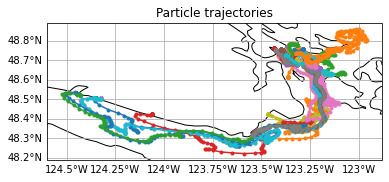

In [4]:
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/5b_TurnPoint_Dilbit_2019-01-14_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/5b_TurnPoint_Dilbit_2019-01-20_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/5b_TurnPoint_Dilbit_2020-01-11_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/5b_TurnPoint_Dilbit_2020-01-16_OP_D50_wp3.nc');

#### English Bay BunkerC spill trajectories

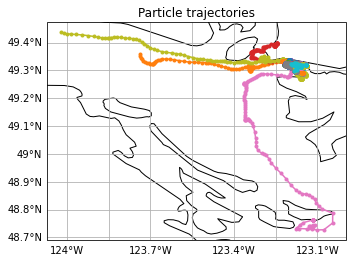

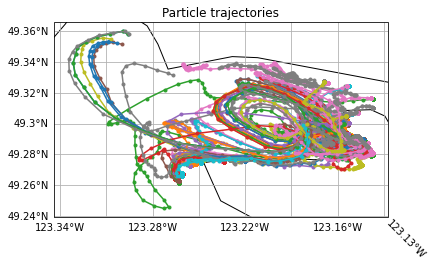

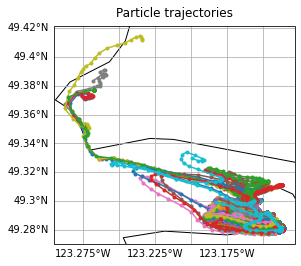

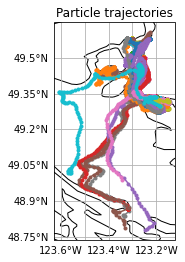

In [6]:
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/6a_VancouverHarbour_BunkerC_2019-07-16_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/6a_VancouverHarbour_BunkerC_2019-07-25_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/6a_VancouverHarbour_BunkerC_2020-07-13_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/6a_VancouverHarbour_BunkerC_2020-07-21_OP_D50_wp3.nc');

#### Port Renfrew (Juan de Fuca Strait) BunkerC spill trajectories

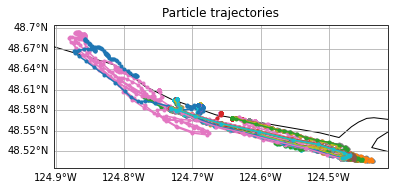

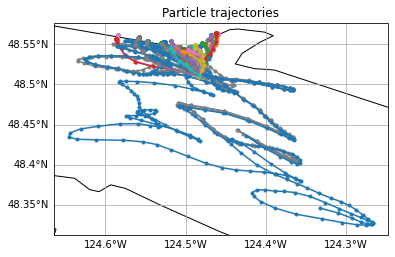

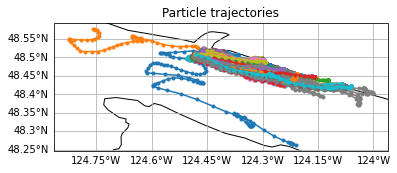

In [8]:
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/7a_JStrait_BunkerC_2019-01-18_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/7a_JStrait_BunkerC_2020-01-03_OP_D50_wp3.nc');
plotTrajectoriesFile('results/Ocean-Parcels-Final-Files/7a_JStrait_BunkerC_2020-01-06_OP_D50_wp3.nc');
